## Setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

### Set the Paths

In [84]:
import pathlib

# set the path to the serialized model after training
MODEL_PATH = pathlib.Path("models/saved/screenshot_classifier.model")
print(f"Model will be saved to {MODEL_PATH}")

# define the path to the output learning rate finder plot and
# training history plot
LRFIND_PLOT_PATH = os.path.sep.join(["output", "lrfind_plot.png"])
TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot.png"])

data_dir = pathlib.Path("data/in_game_classifier/train")
assert data_dir.is_dir()

test_dir = pathlib.Path("data/in_game_classifier/test")
assert test_dir.is_dir()

Model will be saved to models/saved/screenshot_classifier.model


In [5]:
train_game_dir = data_dir / 'game'
train_not_game_dir = data_dir / 'not_game'

test_game_dir = test_dir / 'game'
test_not_game_dir = test_dir / 'not_game'

assert train_game_dir.is_dir()
assert train_not_game_dir.is_dir()
assert test_game_dir.is_dir()
assert test_not_game_dir.is_dir()

In [8]:
num_game_tr = len(os.listdir(train_game_dir))
num_not_game_tr = len(os.listdir(train_not_game_dir))

num_game_test = len(os.listdir(test_game_dir))
num_not_game_test = len(os.listdir(test_not_game_dir))

total_train = num_game_tr + num_not_game_tr
total_test = num_game_test + num_not_game_test

print(("-" * 30), " Training Set", ("-" * 30))
print(f"Game Images: {num_game_tr}")
print(f"Non-Game Images: {num_not_game_tr}")
print()
print(("-" * 30), " Test Set ", ("-" * 30))
print(f"Game Images: {num_game_test}")
print(f"Non-Game Images: {num_not_game_test}")
print()
print("=" * 75)
print(f"Total Training Images: {total_train}")
print(f"Total Test Images: {total_test}")

------------------------------  Training Set ------------------------------
Game Images: 194
Non-Game Images: 173

------------------------------  Test Set  ------------------------------
Game Images: 37
Non-Game Images: 76

Total Training Images: 367
Total Test Images: 113


In [55]:
# define the size of the training and testing split
TRAIN_SPLIT = 0.75
TEST_SPLIT = 0.25
 
# define the initial learning rate, batch size, and number of epochs
INIT_LR = 1e-2
EPOCHS = 50
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(total_train/BATCH_SIZE)

In [11]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and item.name != ".DS_Store"])
CLASS_NAMES

array(['game', 'not_game'], dtype='<U8')

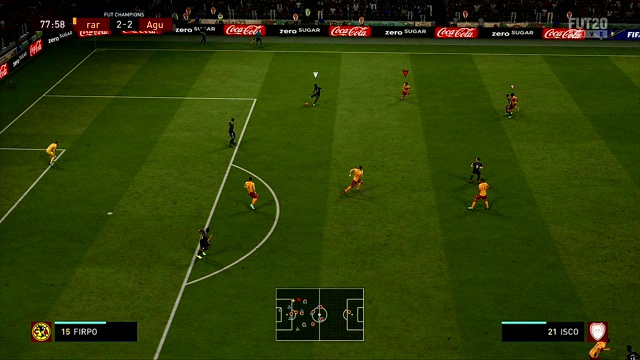

In [13]:
in_game = list(data_dir.glob('game/*.jpg'))

for image_path in in_game[:1]:
    display.display(Image.open(str(image_path)))

In [14]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

## Load using `tf.data`

The above `keras.preprocessing` method is convienient, but has two downsides: 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [23]:
list_train_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'))
list_test_ds = tf.data.Dataset.list_files(str(test_dir/'*/*.jpg'))

In [28]:
# Inspect the train and test dataset list
print("-"*30, " Training", "-"*30)
for f in list_train_ds.take(5):
  print(f.numpy())

print("-"*30, " Test Set", "-"*30)
for f in list_test_ds.take(5):
  print(f.numpy())

------------------------------  Training ------------------------------
b'data/in_game_classifier/train/not_game/glad_00009.jpg'
b'data/in_game_classifier/train/not_game/smwk_00072.jpg'
b'data/in_game_classifier/train/game/glad_00181.jpg'
b'data/in_game_classifier/train/game/reyv_00007.jpg'
b'data/in_game_classifier/train/game/glad_00014.jpg'
------------------------------  Test Set ------------------------------
b'data/in_game_classifier/test/game/glad_00148.jpg'
b'data/in_game_classifier/test/game/glad_00203.jpg'
b'data/in_game_classifier/test/not_game/glad_00103.jpg'
b'data/in_game_classifier/test/not_game/qoix_00045.jpg'
b'data/in_game_classifier/test/game/glad_00204.jpg'


Write a short pure-tensorflow function that converts a file paths to an (image_data, label) pair:

In [29]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [30]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [31]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [37]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_train_ds = list_train_ds.map(process_path, num_parallel_calls=AUTOTUNE)

labeled_test_ds = list_test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [33]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True]


### Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [34]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [38]:
train_ds = prepare_for_training(labeled_train_ds)
test_ds = prepare_for_training(labeled_test_ds)

image_batch, label_batch = next(iter(train_ds))

---
## Inspect the Datset

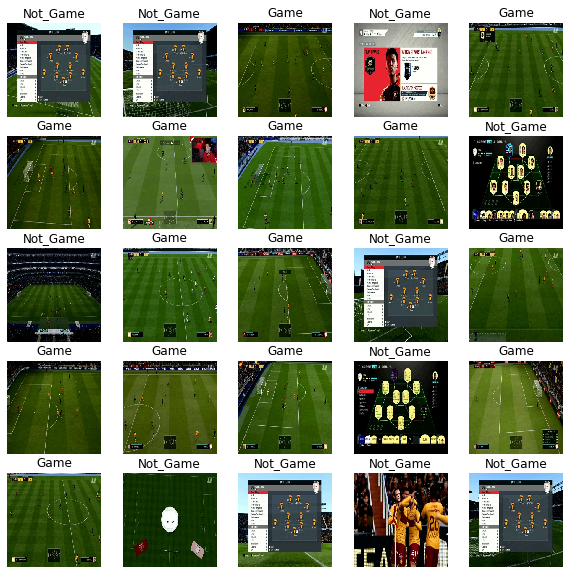

In [39]:
show_batch(image_batch.numpy(), label_batch.numpy())

---
## Build the Model

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, SeparableConv2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import SGD

In [67]:
# Create the model
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [68]:
class FireDetectionNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# CONV => RELU => POOL
		model.add(SeparableConv2D(16, (7, 7), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		
        # CONV => RELU => POOL
		model.add(SeparableConv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# (CONV => RELU) * 2 => POOL
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		
        # first set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# second set of FC => RELU layers
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [73]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, momentum=0.9,
	decay=INIT_LR / EPOCHS)

model = FireDetectionNet.build(width=IMG_WIDTH, height=IMG_HEIGHT, depth=3,
	classes=2)

model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [74]:
# # Compile the model
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [75]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_6 (Separabl (None, 224, 224, 16)      211       
_________________________________________________________________
activation_8 (Activation)    (None, 224, 224, 16)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
separable_conv2d_7 (Separabl (None, 112, 112, 32)      688       
_________________________________________________________________
activation_9 (Activation)    (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 112, 112, 32)     

---
## Train the Model

In [ ]:
# # train the network
# print("[INFO] training network...")
# H = model.fit_generator(
# 	aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
# 	validation_data=(testX, testY),
# 	steps_per_epoch=trainX.shape[0] // config.BATCH_SIZE,
# 	epochs=config.NUM_EPOCHS,
# 	class_weight=classWeight,
# 	verbose=1)

In [76]:
# Train the model
history = model.fit_generator(
    train_ds,
    steps_per_epoch=total_train // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_ds,
    validation_steps=total_test // BATCH_SIZE,
    verbose=1
)
print("[INFO] Model finished fitting...")

Epoch 1/50
11/11 [==============================] - 107s 10s/step - loss: 0.3238 - accuracy: 0.8665 - val_loss: 0.6695 - val_accuracy: 0.6562
Epoch 2/50
11/11 [==============================] - 96s 9s/step - loss: 0.0954 - accuracy: 0.9631 - val_loss: 0.5113 - val_accuracy: 0.8958
Epoch 3/50
11/11 [==============================] - 89s 8s/step - loss: 0.0490 - accuracy: 0.9830 - val_loss: 0.3799 - val_accuracy: 0.8958
Epoch 4/50
11/11 [==============================] - 76s 7s/step - loss: 0.0466 - accuracy: 0.9858 - val_loss: 0.3671 - val_accuracy: 0.9271
Epoch 5/50
11/11 [==============================] - 71s 6s/step - loss: 0.0730 - accuracy: 0.9830 - val_loss: 0.3745 - val_accuracy: 0.8750
Epoch 6/50
11/11 [==============================] - 66s 6s/step - loss: 0.0465 - accuracy: 0.9886 - val_loss: 0.4022 - val_accuracy: 0.8750
Epoch 7/50
11/11 [==============================] - 63s 6s/step - loss: 0.0639 - accuracy: 0.9773 - val_loss: 0.3618 - val_accuracy: 0.8542
Epoch 8/50
11/11 [

---
## Evaluate the model

In [79]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(test_ds, steps=11)

print(predictions)
# print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=CLASS_NAMES))

[INFO] evaluating network...
[[9.99987364e-01 1.25977640e-05]
 [1.42091312e-05 9.99985814e-01]
 [2.60943089e-05 9.99973893e-01]
 [3.79273348e-04 9.99620676e-01]
 [2.61481182e-05 9.99973893e-01]
 [9.99999404e-01 6.31802266e-07]
 [2.96960962e-07 9.99999762e-01]
 [5.78460504e-06 9.99994159e-01]
 [9.99999762e-01 2.30054951e-07]
 [9.99998212e-01 1.78530934e-06]
 [8.10474376e-06 9.99991894e-01]
 [9.98475969e-01 1.52405782e-03]
 [9.99963760e-01 3.62803403e-05]
 [9.99933243e-01 6.67257482e-05]
 [6.43622343e-07 9.99999404e-01]
 [1.72950253e-01 8.27049732e-01]
 [1.74532215e-05 9.99982595e-01]
 [8.51632467e-06 9.99991536e-01]
 [1.90957089e-05 9.99980927e-01]
 [2.72042871e-05 9.99972820e-01]
 [9.99997139e-01 2.88012166e-06]
 [9.99993682e-01 6.37291259e-06]
 [2.27028136e-06 9.99997735e-01]
 [1.36375611e-05 9.99986410e-01]
 [8.08548393e-08 9.99999881e-01]
 [9.95992601e-01 4.00740094e-03]
 [3.15429133e-05 9.99968410e-01]
 [5.78014915e-05 9.99942183e-01]
 [2.84488465e-06 9.99997139e-01]
 [3.60938969e-

In [83]:
# serialize the model to disk
print(f"[INFO] serializing network to {MODEL_PATH}")
model.save(str(MODEL_PATH))

[INFO] serializing network to models/saved/screenshot_classifier.model
INFO:tensorflow:Assets written to: models/saved/screenshot_classifier.model/assets


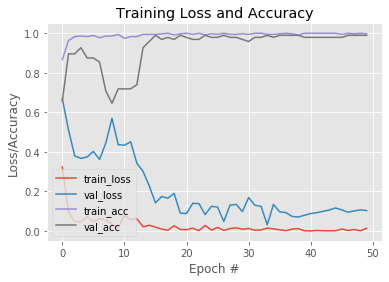

In [86]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(TRAINING_PLOT_PATH)

In [ ]:
# define the path to the output directory that will store our final
# output with labels/annotations along with the number of images to
# sample
OUTPUT_IMAGE_PATH = os.path.sep.join(["output", "examples"])
SAMPLE_SIZE = 50